This notebook explores using Shepard's Method Inverse Distance Weighting 

In [19]:
#########################
### Import Code Stuff ###
#########################

### Numpy and Scipy
import numpy as np
from scipy.stats import binned_statistic, binned_statistic_2d

### Astropy FITS/Table handling
from astropy.io import fits, ascii
from astropy.table import Table, Column, vstack

#astropy coorindates/units
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 22})

### Geometry
import lmcgeometry as lgeo

### Other
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

In [20]:
def add_noise(quant,quant_err,distribution='normal'):
    '''
    Add noise to data and return new values
    
    Parameters:
    ----------
        quant: 1d array-like data to add noise to
        quant_err: 1d array-like object of errors for quant
        distribution: which distribution to use 'normal', 'poisson', 'uniform'
    
    return: 
    ------
        1d array-like object of data with added noise
    
    '''
    if distribution == 'normal':
        return np.random.normal(quant,quant_err)
    if distribution == 'poisson':
        return quant + np.random.poisson(quant_err)
    if distribution == 'uniform':
        return np.random.uniform(-quant_err+quant,quant+quant_err)
    
def mad(x):
    '''
    Calculate median absolute deviation:
        
        MAD = median(x_i-median(x))
        
    Inputs:
    ------
        x: data to calculate mad of 
    
    Outputs:
    -------
        mad: median absolute deviation
    '''
    return np.median(x-np.median(x))

def salaris(mh,am):
    '''
    Calculate the Salaris correction (Salaris et al. 1993)
    
    Inputs:
    ------
        mh: [M/H] 
        am: [ALPHA/H]
    
    Outputs:
    -------
        feh adjusted metallicity
    '''
    feh = mh + np.log10((0.638*(10**(am)))+0.362)
    return feh

def LMCdisk_cart(ra, dec):
    
    '''
    Calculate the position of stars in the LMC disk plane with 
    center at the LMC center in cartesian coordinates (x, y).
    This also calculates the distance to the individual stars.
    
    This follows van der Marel and Cioni 2001 
    
    Input
    - ra: right ascension of stars
    - dec: declination of stars
    
    Output
    - x_m: x coordinate
    - y_m: y coordinate
    - dis: distance to LMC star
    '''
    alph0 = np.radians(82.25) #right ascension of center of LMC
    delt0 = np.radians(-69.50) #declination of center of LMC
    pa = np.radians(149.23+90.00) #146.37 #position angle of line of nodes
    io = np.radians(25.86) #27.81 #inclination of LMC disk
    d0 = 49.90 #distance to center of LMC
    
    #convert to radians
    ra = np.radians(ra)
    dec = np.radians(dec)
    sd = np.sin(delt0)
    cd = np.cos(delt0)
    
    cr = cd*np.cos(dec)*np.cos(ra-alph0)+sd*np.sin(dec)
    srcp = -np.cos(dec)*np.sin(ra-alph0)
    srsp = cd*np.sin(dec) - sd*np.cos(dec)*np.cos(ra-alph0)
    dis = d0*np.cos(io)/(np.cos(io)*cr - np.sin(io)*np.cos(pa)*srsp + np.sin(io)*np.sin(pa)*srcp)
    
    x_m = dis*srcp
    y_m = dis*(np.cos(io)*srsp + np.sin(io)*cr) - d0*np.sin(io)
    
    return x_m, y_m, dis

#calculate absolute mag
def absmag(magnitude,distance):
    '''
    - magnitude: apparent magnitude of star
    - distance: distance to star in kpc
    Calculate the absolute magnitude of star
    '''
    absm = []
    absm.append(magnitude-5.0*np.log10(distance*1000)+5.0)
    absm = np.squeeze(np.array(absm))
    return absm

In [21]:
### Import Data
lmc = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/lmc_rgbmembers.r13-l33-58672.fits.gz',1)
cln = np.where((lmc['FE_H']>-9999.0)&(lmc['AK_TARG']>-9999.0)&(lmc['LOGG']>0.0)&(lmc['M_H_ERR']>-90.0)&
                (lmc['C_FE']>-9999.0)&(lmc['N_FE']>-9999.0))

lmc = lmc[cln]

elems = ['M_H','C_FE','N_FE','O_FE','NA_FE','MG_FE','AL_FE','SI_FE','P_FE','S_FE','K_FE','CA_FE','TI_FE',
         'TIII_FE','V_FE','CR_FE','MN_FE','FE_H','CO_FE','NI_FE','CU_FE','GE_FE','RB_FE','CE_FE','ND_FE','YB_FE']

labs = ['[M_H]','[C/Fe]','[N/Fe]','[O/Fe]','[Na/Fe]','[Mg/Fe]','[Al/Fe]','[Si/Fe]','[P/Fe]','[S/Fe]','[K/Fe]',
        '[Ca/Fe]','[Ti/Fe]','[TiII/Fe]','[V/Fe]','[Cr/Fe]','[Mn/Fe]','[Fe/H]','[Co/Fe]','[Ni/Fe]','[Cu/Fe]',
        '[Ge/Fe]','[Rb/Fe]','[Ce/Fe]','[Nd/Fe]','[Yb/Fe]']

### LMC Geometry
x,y,dist = lgeo.LMCdisk_cart(lmc['RA'],lmc['DEC'])
radius = lgeo.elliptical_radius(x,y)

### PARSEC
parsecall2 = ascii.read('/Users/joshuapovick/Desktop/Research/parsec/parsec3_3.dat',format='basic', delimiter='\s')

rgb2 = np.where(parsecall2['label']==3)
parsec2 = parsecall2[rgb2]

# linAge: 0.5e8 - 0.5e9, 0.35e8; MH: -2.6 - 0.1, 0.1 '''Only goes to -2.2; Only 7 LMC less than -2.2'''
youngest_parsec = ascii.read('/Users/joshuapovick/Desktop/Research/parsec/parsec3.4_0.5e8_0.5e9_0.35e8.dat',
                          format='basic',delimiter='\s')

# linAge: 0.5e9 - 7.0e9, 0.5e9; MH: -2.6 - 0.1, 0.1 '''Only goes to -2.2; Only 7 LMC less than -2.2'''
young_parsec = ascii.read('/Users/joshuapovick/Desktop/Research/parsec/parsec3.4_0.5_7.0.dat',format='basic',
                          delimiter='\s')
# linAge: 7.5e9 - 1.4e10, 0.5e9; MH: -2.6 - 0.1, 0.1 '''Only goes to -2.2; Only 7 LMC less than -2.2'''
old_parsec = ascii.read('/Users/joshuapovick/Desktop/Research/parsec/parsec3.4_7.5_14.0.dat',format='basic',
                          delimiter='\s')

parsec = vstack([youngest_parsec,young_parsec,old_parsec])

rgb = np.where(parsec['label']==3)
parsec = parsec[rgb]

(array([ 690.,  403.,  422.,  994.,  681., 1397., 3279., 1724., 1745.,
        3611.]),
 array([ 8.1  ,  8.295,  8.49 ,  8.685,  8.88 ,  9.075,  9.27 ,  9.465,
         9.66 ,  9.855, 10.05 ]),
 <BarContainer object of 10 artists>)

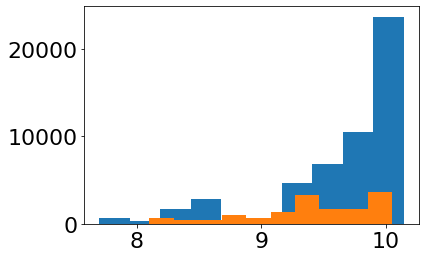

In [22]:
plt.hist(parsec['logAge'])
plt.hist(parsec2['logAge'])

In [23]:
### Age of Universe
H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

### Get Solar Fractions
# {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}

ac = [8.39,7.78,8.66,7.53,6.31,7.14,7.51,7.45]

xh_sol = []
for i in range(len(ac)):
    xh_sol.append(ac[i]-12.0)
    
xm_sol = 10**np.asarray(xh_sol)/sum(10**np.asarray(xh_sol))

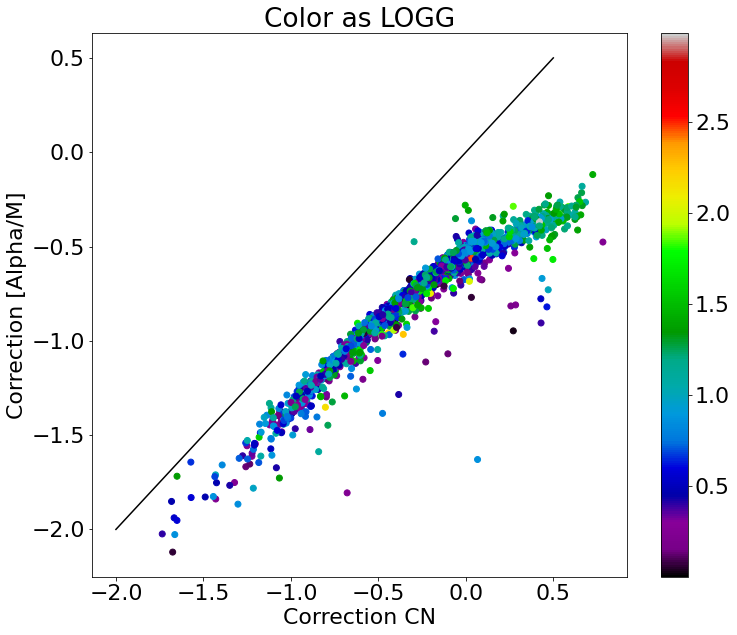

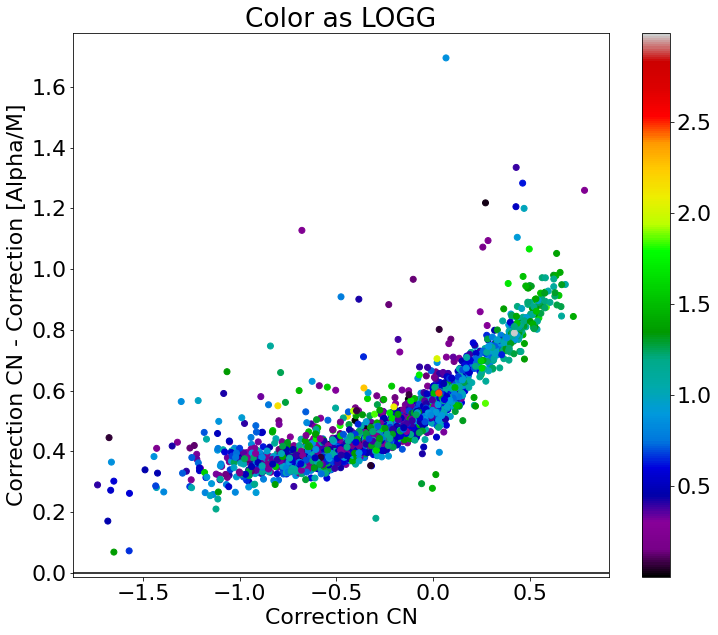

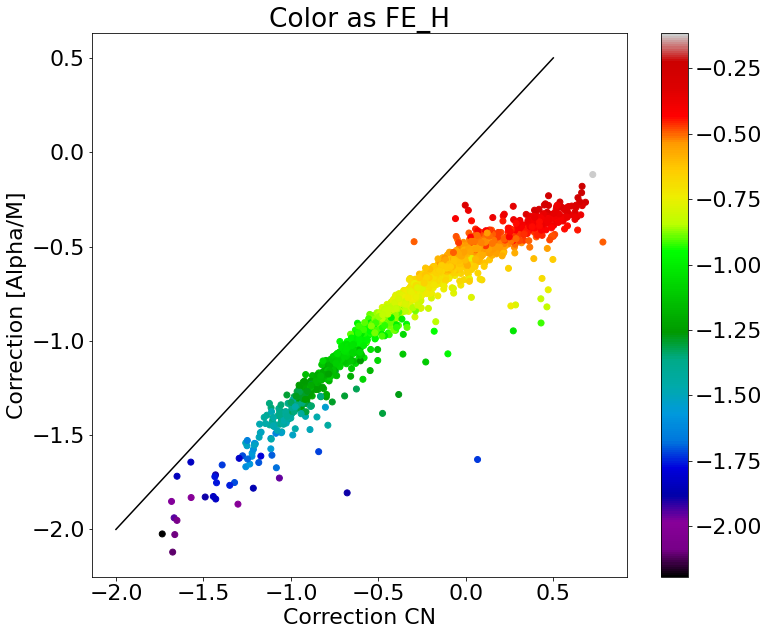

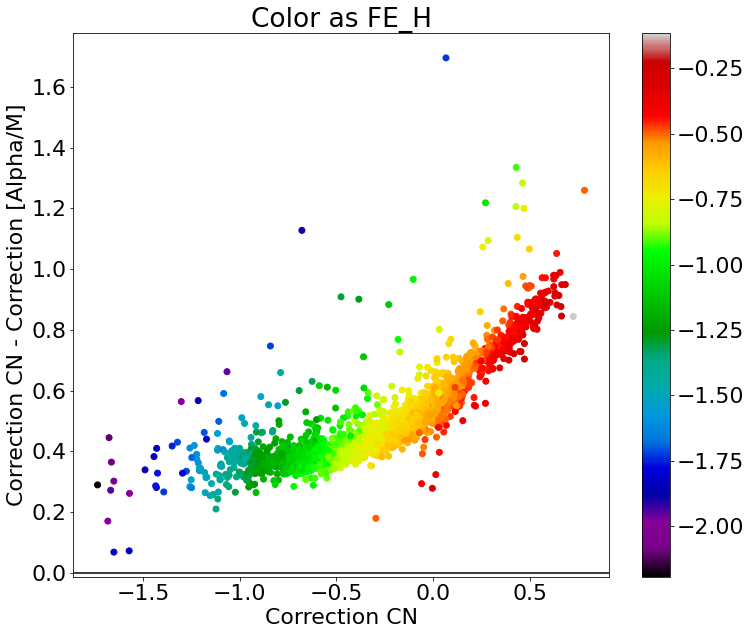

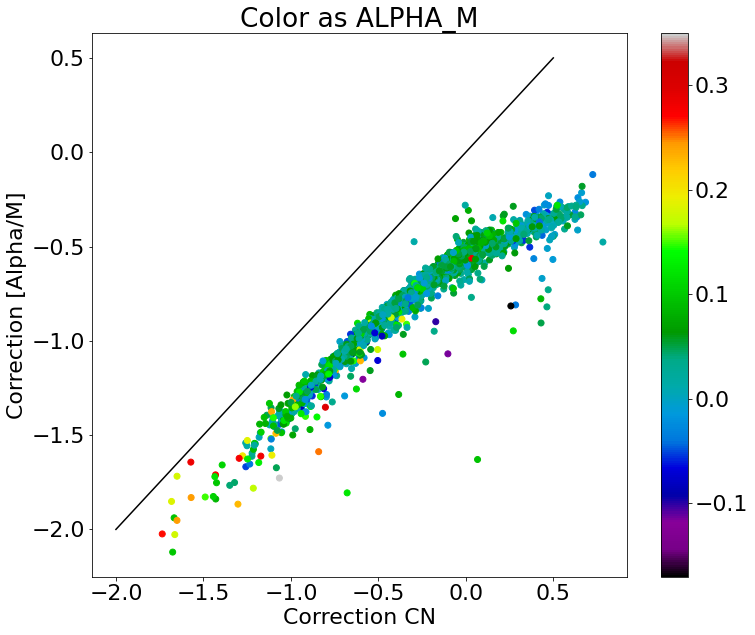

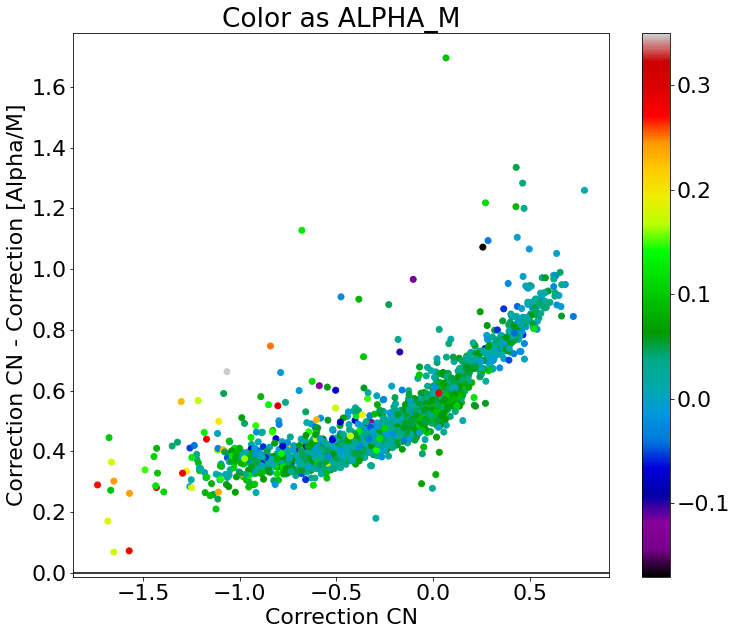

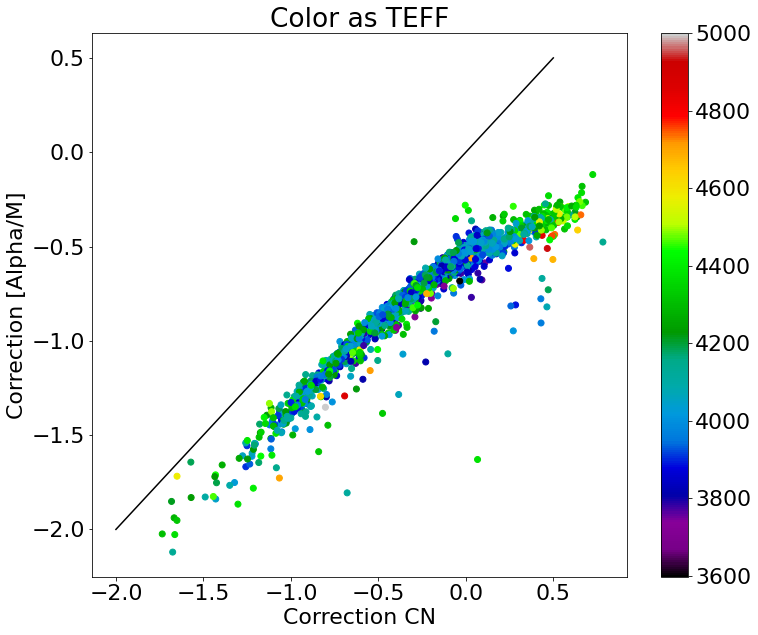

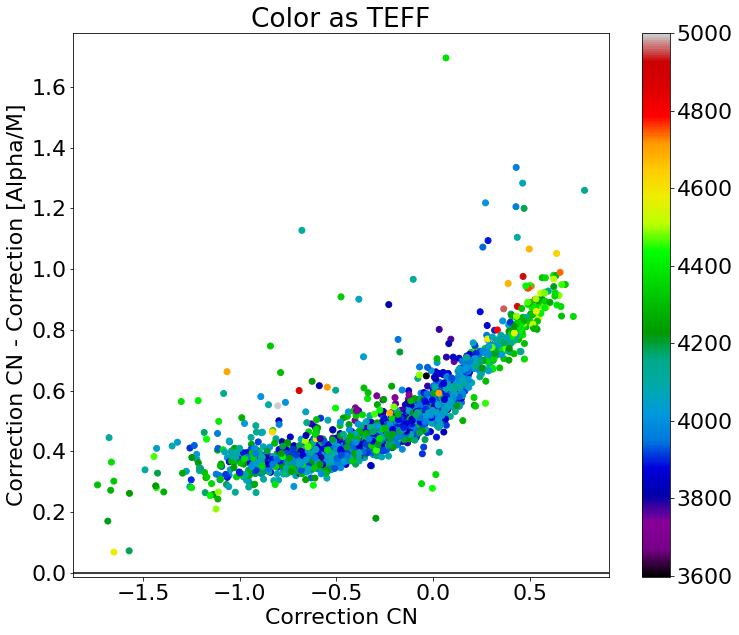

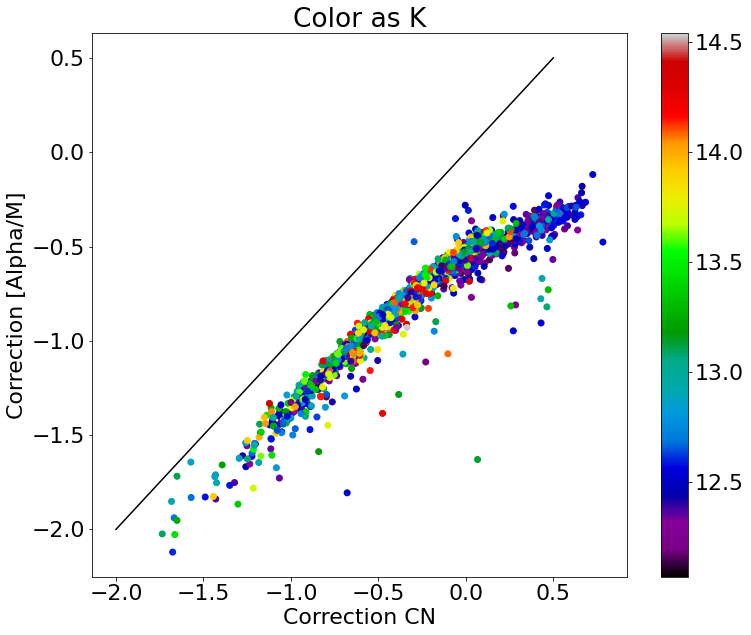

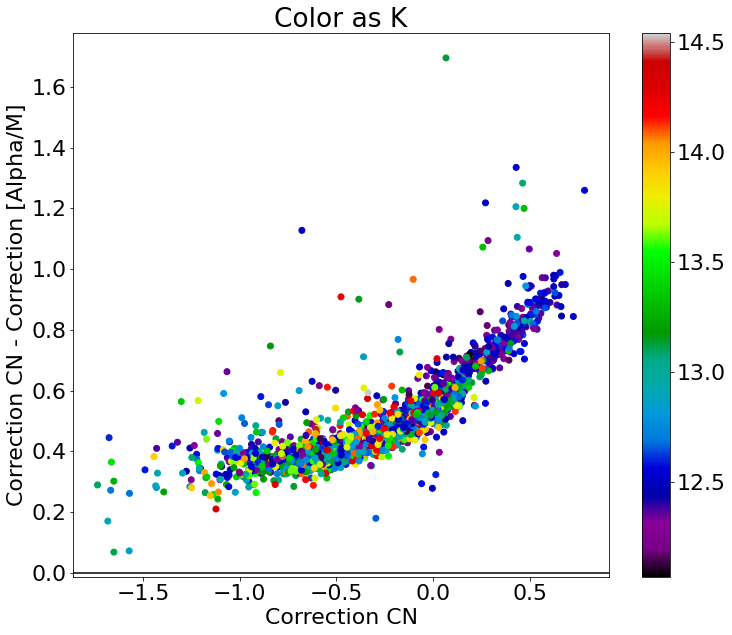

In [24]:
# xm_sol[0]*10**(lmc['C_FE']+lmc['FE_H']-lmc['M_H'])

x_C = xm_sol[0]*10**(lmc['C_FE']+lmc['FE_H']-lmc['M_H'])
x_N = xm_sol[1]*10**(lmc['N_FE']+lmc['FE_H']-lmc['M_H'])
ffac = (x_C+x_N)/sum(xm_sol[0:2])


sal_feh_alp = salaris(lmc['M_H'],lmc['ALPHA_M'])
sal_feh_cn = salaris(lmc['M_H'],ffac)

# ### Correspondence 
# plt.figure(figsize=[12,10])
# plt.scatter(sal_feh_cn,sal_feh_alp,c=lmc['LOGG'],cmap='nipy_spectral')
# plt.plot([-2.0,0.5],[-2.0,0.5],c='k')
# plt.colorbar()

# plt.title(r'Color as Log(g)')
# plt.xlabel(r'Correction CN')
# plt.ylabel(r'Correction [Alpha/M]')
# plt.show()

# ### Offset
# plt.figure(figsize=[12,10])
# plt.scatter(sal_feh_cn,sal_feh_cn-sal_feh_alp,c=lmc['LOGG'],cmap='nipy_spectral')
# plt.colorbar()

# plt.title(r'Color as Log(g)')
# plt.xlabel(r'Correction CN')
# plt.ylabel(r'Correction CN- Correction [Alpha/M]')
# plt.show()

sal_cols = [lmc['LOGG'],lmc['FE_H'],lmc['ALPHA_M'],lmc['TEFF'],lmc['K']]
sal_labs = ['LOGG','FE_H','ALPHA_M','TEFF','K','C_FE','N_FE']
for i in range(len(sal_cols)):
    ### Correspondence 
    plt.figure(figsize=[12,10])
    plt.scatter(sal_feh_cn,sal_feh_alp,c=sal_cols[i],cmap='nipy_spectral')
    plt.plot([-2.0,0.5],[-2.0,0.5],c='k')
    plt.colorbar()

    plt.title(r'Color as {}'.format(sal_labs[i]))
    plt.xlabel(r'Correction CN')
    plt.ylabel(r'Correction [Alpha/M]')
    plt.show()

    ### Offset
    plt.figure(figsize=[12,10])
    plt.scatter(sal_feh_cn,sal_feh_cn-sal_feh_alp,c=sal_cols[i],cmap='nipy_spectral')
    plt.axhline(0.0,c='k')
    plt.colorbar()

    plt.title(r'Color as {}'.format(sal_labs[i]))
    plt.xlabel(r'Correction CN')
    plt.ylabel(r'Correction CN - Correction [Alpha/M]')
    plt.show()

Feuillet et al. 2016 finds that the best parameters for giant stars is Temperature, magnitude, [Fe/H], and Log(g)

In [25]:
### Inital Interpolator setup
from photutils.utils import ShepardIDWInterpolator as idw

val_arr = np.array([parsec['logTe'],parsec['Ksmag'],np.log10(parsec['Z']/0.02),parsec['logg']]).T
interpol = idw(val_arr,parsec['logAge'])

In [26]:
age_distrs = []

for i in tqdm_notebook(range(len(lmc)),desc='Done?'):
    # temperature
    teff = lmc['TEFF'][i]
    teff_err = lmc['TEFF_ERR'][i]
    
    # photometry 
    ra = lmc['RA'][i]
    dec = lmc['DEC'][i]
    ks = lmc['K'][i]
    ks_err = lmc['K_ERR'][i]
    ak = lmc['AK_TARG'][i]
    
    # abundances
    mh = lmc['M_H'][i]
    mh_err = lmc['M_H_ERR'][i]
    am = lmc['ALPHA_M'][i]
    am_err = lmc['ALPHA_M_ERR'][i]
#     cfe = lmc['C_FE'][i]
#     cfe_err = lmc['C_FE_ERR'][i]
#     nfe = lmc['N_FE'][i]
#     nfe_err = lmc['N_FE_ERR'][i]
    feh = lmc['FE_H'][i]
    feh_err = lmc['FE_H_ERR'][i]
    
    # surface gravity
    lgg = lmc['LOGG'][i]
    lgg_err = lmc['LOGG_ERR'][i]
    
    noisy = []
    distr = []
    for j in range(750):
       
        # calculate noisy temperature
        teff_new = add_noise(teff,teff_err) 
        lgteff_new = np.log10(teff_new)
    
        # Calculate noisy K magnitude
        _, _, dist = LMCdisk_cart(ra,dec)
        
        ks_new = add_noise(ks,ks_err)
            
        absK_new = absmag(ks_new,dist) - ak
            
        # Calculate noisy Salaris correction
        
#         x_C_new = sol_xm[0]*10**(add_noise(cfe,cfe_err)+
#                                  add_noise(feh,feh_err)-add_noise(mh,mh_err))
#         x_N_new = sol_xm[1]*10**(add_noise(nfe,nfe_err)+
#                                  add_noise(feh,feh_err)-add_noise(mh,mh_err))
        
#         ffac_new = (x_C_new+x_N_new)/sum(sol_xm[0:2])
        
        mh_new = add_noise(mh,mh_err)
        am_new = add_noise(am,am_err)
        
        # Calculate noisy surface gravity
        lgg_new = add_noise(lgg,lgg_err)
            
        # calculate noisy age
        noisy.append(interpol(np.array([lgteff_new,absK_new,salaris(mh_new,am_new),lgg_new])))
    
    age_distrs.append(noisy)

parages = [] 
devs = []
for k in tqdm_notebook(range(len(age_distrs))):
    devs.append(mad(age_distrs[k]))
    parages.append(np.median(age_distrs[k]))

(array([255.,  15.,  55., 167., 181., 113.,  72.,  67.,  82.,  68.,  77.,
         71.,  58.,  57.,  48.,  68.,  51.,  71.,  59.,  42.,  47.,  63.,
        299., 296., 206.]),
 array([ 0.05      ,  0.59535224,  1.14070448,  1.68605671,  2.23140895,
         2.77676119,  3.32211343,  3.86746566,  4.4128179 ,  4.95817014,
         5.50352238,  6.04887461,  6.59422685,  7.13957909,  7.68493133,
         8.23028357,  8.7756358 ,  9.32098804,  9.86634028, 10.41169252,
        10.95704475, 11.50239699, 12.04774923, 12.59310147, 13.13845371,
        13.68380594]),
 <BarContainer object of 25 artists>)

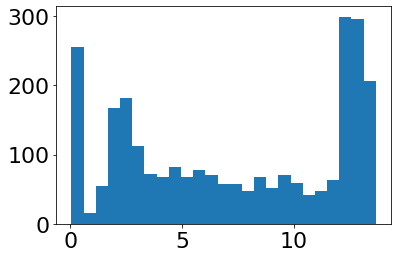

In [27]:
plt.hist(10**np.asarray(parages)/10**9,bins=25)

(array([ 94.,  12., 163., 222., 129.,  86.,  95.,  83.,  99.,  85.,  60.,
         68.,  76.,  68.,  90.,  51.,  54., 194., 404., 244.]),
 array([ 0.07714921,  0.75748204,  1.43781488,  2.11814772,  2.79848055,
         3.47881339,  4.15914623,  4.83947906,  5.5198119 ,  6.20014474,
         6.88047757,  7.56081041,  8.24114325,  8.92147609,  9.60180892,
        10.28214176, 10.9624746 , 11.64280743, 12.32314027, 13.00347311,
        13.68380594]),
 <BarContainer object of 20 artists>)

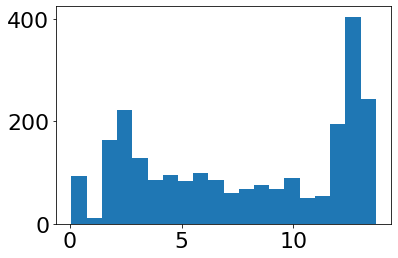

In [28]:
### Bloop Cut
kmags = [0.7,1.]
colos = [13.5,12.]

zbloop = np.polyfit(kmags, colos, 1)
pbloop = np.poly1d(zbloop)

bloop_cut = np.where(lmc['K']>pbloop(lmc['J']-lmc['K'])+0.1)

plt.hist(10**np.asarray(parages)[bloop_cut]/10**9,bins=20)

In [29]:
# Diane Feuillet
pdfout = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/LMC_DR16_all_PDF.fits.gz', 1)
_, lmc_ind, pdfout_ind = np.intersect1d(lmc['APOGEE_ID'],pdfout['OBJ'],return_indices=True)

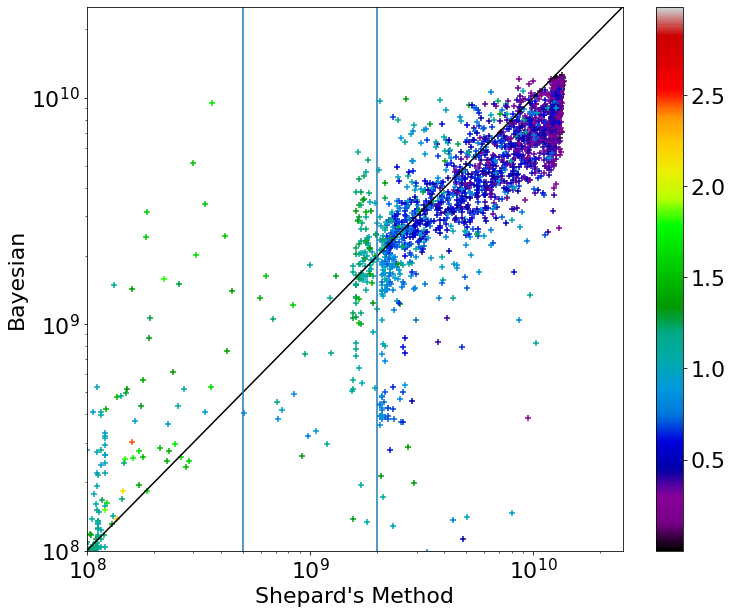

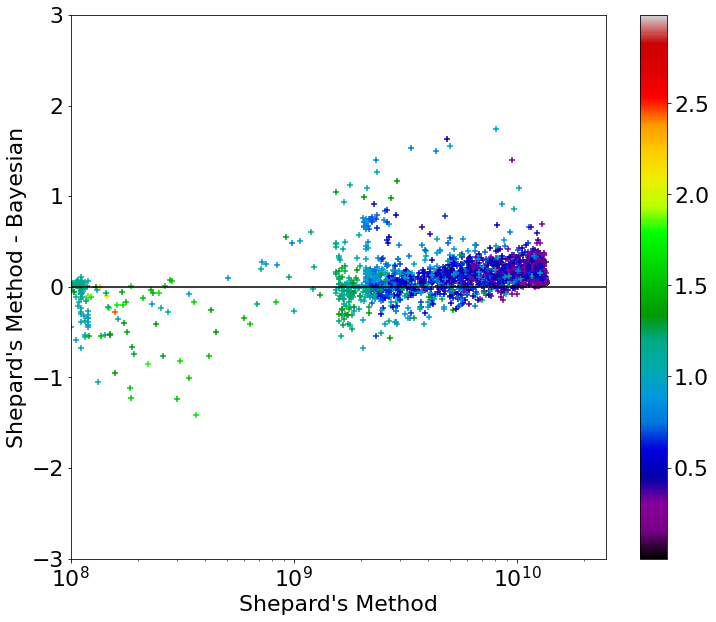

In [30]:
plt.figure(figsize=[12,10])
plt.scatter(10**np.asarray(parages)[lmc_ind],10**pdfout['P_MEAN'][pdfout_ind],
            c=lmc['LOGG'][lmc_ind],marker='+',cmap='nipy_spectral')
plt.colorbar()
plt.xscale('log')
plt.yscale('log')
plt.plot(10**np.array([7,8,9,10,11,12,13]),10**np.array([7,8,9,10,11,12,13]),c='k')
plt.ylim(10**8,10**10.4)
plt.xlim(10**8,10**10.4)

plt.axvline(0.5*10**9)
plt.axvline(2.0*10**9)

plt.xlabel(r'''Shepard's Method''')
plt.ylabel(r'Bayesian')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(10**np.asarray(parages)[lmc_ind],
            (np.asarray(parages)[lmc_ind]-pdfout['P_MEAN'][pdfout_ind]),
            c=lmc['LOGG'][lmc_ind],marker='+',cmap='nipy_spectral')
plt.axhline(0,c='k')
plt.colorbar()
plt.xscale('log')
# plt.yscale('log')
# plt.plot(10**np.array([7,8,9,10,11,12,13]),10**np.array([7,8,9,10,11,12,13]),c='k')
plt.ylim(-3,3)
plt.xlim(10**8,10**10.4)

plt.ylabel(r'''Shepard's Method - Bayesian''')
plt.xlabel(r'''Shepard's Method''')
plt.show()

In [31]:
len(np.squeeze(np.where(np.asarray(parages)>np.log10(ageU))))/len(parages)

0.03786707882534776

In [32]:
cat = Table()
col_id = Column(np.asarray(lmc['APOGEE_ID']),name='APOGEE_ID')
col_age = Column(np.asarray(parages),name='AGE')
col_dev = Column(np.asarray(devs),name='AGE_ERR')
col_dist = Column(np.asarray(age_distrs),name='DIST')

cat.add_column(col_id)
cat.add_column(col_age)
cat.add_column(col_dev)
cat.add_column(col_dist)

# cat.write('shepards_ages.fits',for mat='fits')#,overwrite=True)

(array([  686.,   371.,  1651.,  2830.,   469.,   683.,  4712.,  6868.,
        10473., 23711.]),
 array([ 7.69897 ,  7.943686,  8.188402,  8.433118,  8.677834,  8.92255 ,
         9.167266,  9.411982,  9.656698,  9.901414, 10.14613 ]),
 <BarContainer object of 10 artists>)

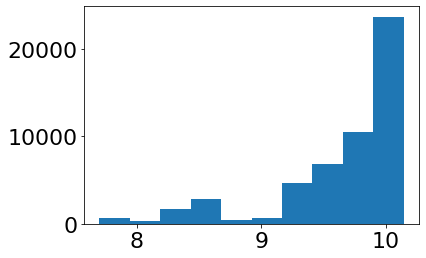

In [33]:
plt.hist(parsec['logAge'])

In [34]:
np.unique(parsec['logAge'])

7.69897
7.92942
8.07918
8.19033
8.27875
8.35218
8.41497
8.46982
8.51851
8.56229
8.60206


In [35]:
10**10.14613

14000063322.395283

In [64]:
step = 15*10**7
print('Step: {:.3e}'.format(step))
for i in range(94):
    print('{:.3e}'.format(14*10**9-(i*(step))))
    j = 94 - i
    if i%17 == 0:
        print(r'-----')

Step: 1.500e+08
1.400e+10
-----
1.385e+10
1.370e+10
1.355e+10
1.340e+10
1.325e+10
1.310e+10
1.295e+10
1.280e+10
1.265e+10
1.250e+10
1.235e+10
1.220e+10
1.205e+10
1.190e+10
1.175e+10
1.160e+10
1.145e+10
-----
1.130e+10
1.115e+10
1.100e+10
1.085e+10
1.070e+10
1.055e+10
1.040e+10
1.025e+10
1.010e+10
9.950e+09
9.800e+09
9.650e+09
9.500e+09
9.350e+09
9.200e+09
9.050e+09
8.900e+09
-----
8.750e+09
8.600e+09
8.450e+09
8.300e+09
8.150e+09
8.000e+09
7.850e+09
7.700e+09
7.550e+09
7.400e+09
7.250e+09
7.100e+09
6.950e+09
6.800e+09
6.650e+09
6.500e+09
6.350e+09
-----
6.200e+09
6.050e+09
5.900e+09
5.750e+09
5.600e+09
5.450e+09
5.300e+09
5.150e+09
5.000e+09
4.850e+09
4.700e+09
4.550e+09
4.400e+09
4.250e+09
4.100e+09
3.950e+09
3.800e+09
-----
3.650e+09
3.500e+09
3.350e+09
3.200e+09
3.050e+09
2.900e+09
2.750e+09
2.600e+09
2.450e+09
2.300e+09
2.150e+09
2.000e+09
1.850e+09
1.700e+09
1.550e+09
1.400e+09
1.250e+09
-----
1.100e+09
9.500e+08
8.000e+08
6.500e+08
5.000e+08
3.500e+08
2.000e+08
5.000e+07


In [57]:
50000000/10**9

0.05

-2.1930616
-0.11566155


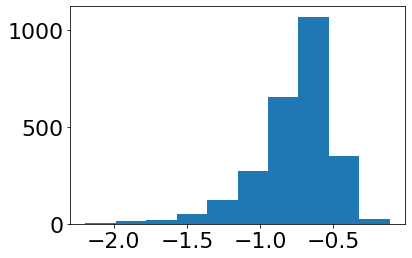

In [47]:
plt.hist(lmc['FE_H'])
print(min(lmc['FE_H']))
print(max(lmc['FE_H']))

0.017376656

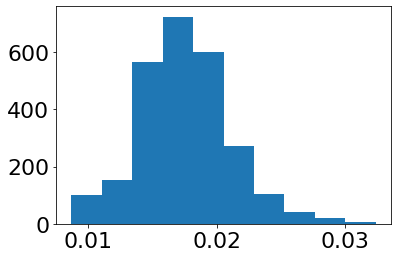

In [50]:
plt.hist(lmc['FE_H_ERR'])
np.median(lmc['FE_H_ERR'])

In [9]:
0.02

500000000

In [54]:
(2.2--0.1)/0.1

23.0

In [14]:
350000000/10**9

0.35

In [17]:
100000000/10**9

0.1

In [42]:
50000000/10**9

0.05

In [70]:
# import glob
# files = glob.glob('/Users/joshuapovick/Desktop/Research/parsec/parsec1.5e8/*')
# parsecs = []
# for i in files:
#     parsecs.append(ascii.read(i,format='basic',delimiter='\s'))
    
# parsectotal = vstack(parsecs)
# parsectotal.write('parsec.fits',format='fits')#,overwrite=True)